### Get the Environment Ready

In [90]:
!wget https://raw.githubusercontent.com/rahulrajpr/references/main/requirements_tf_cert_exam.txt

--2023-03-29 18:37:26--  https://raw.githubusercontent.com/rahulrajpr/references/main/requirements_tf_cert_exam.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87 [text/plain]
Saving to: ‘requirements_tf_cert_exam.txt.2’

requirements_tf_cer 100%[===================>]      87  --.-KB/s    in 0s      

2023-03-29 18:37:26 (2.94 MB/s) - ‘requirements_tf_cert_exam.txt.2’ saved [87/87]



In [91]:
from IPython.core.display import clear_output
!pip install -r requirements_tf_cert_exam.txt
clear_output()

In [92]:
import pandas as pd
import tensorflow as tf
import numpy as np
import scipy 
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import random

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD

In [93]:
print(f'tensorflow version :{tf.__version__}')
print(f'pandas version :{pd.__version__}')
print(f'numpy version :{np.__version__}')
print(f'scipy version :{scipy.__version__}')

tensorflow version :2.10.0
pandas version :1.4.2
numpy version :1.22.4
scipy version :1.7.3


### Get the Helper Functions

In [94]:
!wget https://raw.githubusercontent.com/rahulrajpr/references/main/helper_functions.py
clear_output()

In [95]:
!pip install split_folders
clear_output()

### Get the DataSet

In [96]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json
clear_output()

In [97]:
import json

sentences,labels = [],[]

filename = '/content/sarcasm.json'

with open(filename, 'r') as f:
  datafile = json.load(f)

for item in datafile:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

sentences[:3],labels[:2]

(["former versace store clerk sues over secret 'black code' for minority shoppers",
  "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  "mom starting to fear son's web series closest thing she will have to grandchild"],
 [0, 0])

In [98]:
print(f'length of the sentences : {len(sentences)}')
print(f'length of the label : {len(labels)}')

length of the sentences : 26709
length of the label : 26709


### Lets check the balance of the data

label propotions :
0    0.561047
1    0.438953
dtype: float64



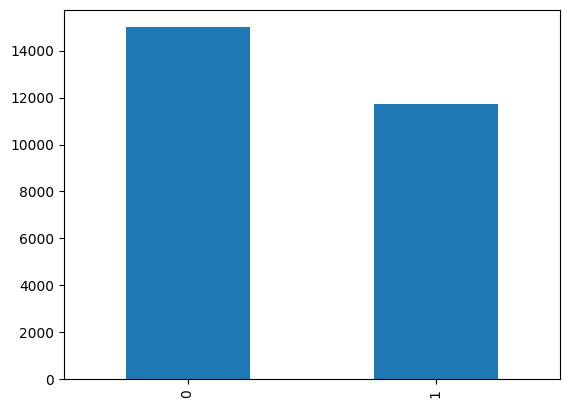

In [99]:
print(f'label propotions :\n{pd.Series(labels).value_counts(normalize = True)}\n')
pd.Series(labels).value_counts().plot(kind = 'bar');

### Convert the dataset into Train and Validations

In [100]:
training_proporsion = 0.8
training_size = int(len(sentences)*training_proporsion)
training_size

21367

In [101]:
train_sentences = sentences[:training_size]
train_labels = labels[:training_size]

val_sentences = sentences[training_size:]
val_labels = labels[training_size:]

len(train_sentences),len(train_labels),len(val_sentences),len(val_labels)

(21367, 21367, 5342, 5342)

> Lets recheck the balance of the datalabels inthe training set

label propotions :
0    0.55932
1    0.44068
dtype: float64



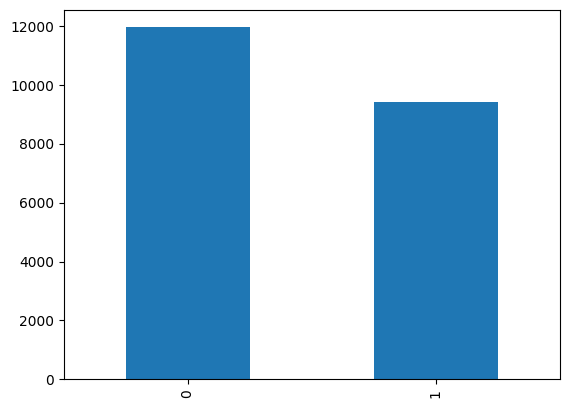

In [102]:
print(f'label propotions :\n{pd.Series(train_labels).value_counts(normalize = True)}\n')
pd.Series(train_labels).value_counts().plot(kind = 'bar');

### Standardize the Text 

In [103]:
import string
def custom_standardization(text):
    x = tf.strings.lower(text) # conver all the text into lowercase
    x = tf.strings.regex_replace(x, '<[^>]*>', '') # replace the html tags with nothing
    x = tf.strings.regex_replace(x, '[' + string.punctuation + ']', '') # replace the punctuations with nothing
    x = x.numpy().decode('utf-8') # convert into a numpy value and decaode the test into utf-8 format
    return x

In [104]:
train_sentences = [custom_standardization(x) for x in train_sentences]
val_sentences = [custom_standardization(x) for x in val_sentences]

### Lets Tokenize the dataset

> Apply the standardization

In [105]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [106]:
vocab_size = 10000
oov_token = '<OOV>'
padding_size = 128

embed_size = 16
trunc_type = 'post'
padding_type = 'post'

In [107]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
tokenizer

In [108]:
tokenizer.fit_on_texts(train_sentences)

In [109]:
len(tokenizer.word_index)

25427

In [110]:
train_sentences = tokenizer.texts_to_sequences(train_sentences)
val_sentences = tokenizer.texts_to_sequences(val_sentences)

In [111]:
train_sentences = pad_sequences(sequences = train_sentences, maxlen = padding_size, padding = padding_type, truncating = trunc_type)
val_sentences = pad_sequences(sequences = val_sentences, maxlen = padding_size, padding = padding_type, truncating = trunc_type)

In [112]:
print(f'train sentences shape : {train_sentences.shape}')
print(f'val sentences shape : {val_sentences.shape}')

train sentences shape : (21367, 128)
val sentences shape : (5342, 128)


### Lets create the Embedding Layer

In [113]:
embedding_layer = layers.Embedding(input_dim = vocab_size, output_dim = embed_size,input_length = padding_size)
embedding_layer

> Test the embedding layer

In [114]:
sample_embed = embedding_layer(train_sentences[:2])
sample_embed, sample_embed.shape

(<tf.Tensor: shape=(2, 128, 16), dtype=float32, numpy=
 array([[[-0.0128286 ,  0.04408796,  0.01521141, ...,  0.01165529,
           0.03911919, -0.04502443],
         [-0.00986283, -0.03898472,  0.02275509, ..., -0.03001555,
           0.0109495 ,  0.00904443],
         [ 0.03533543,  0.03977073,  0.02850355, ...,  0.01106877,
          -0.04803634, -0.00081296],
         ...,
         [ 0.02201258,  0.03702185, -0.00378405, ..., -0.0342112 ,
           0.012015  ,  0.00602939],
         [ 0.02201258,  0.03702185, -0.00378405, ..., -0.0342112 ,
           0.012015  ,  0.00602939],
         [ 0.02201258,  0.03702185, -0.00378405, ..., -0.0342112 ,
           0.012015  ,  0.00602939]],
 
        [[ 0.00765781,  0.04709559, -0.04554653, ...,  0.02959836,
          -0.0314927 , -0.03075354],
         [ 0.02739416,  0.01003019, -0.01578475, ..., -0.02398136,
           0.01375398, -0.00282184],
         [-0.00897706,  0.00083255, -0.04079003, ...,  0.03939598,
           0.01246989, -0.017

In [115]:
train_sentences.shape

(21367, 128)

### Convert the labels also into Np Array


In [116]:
train_labels = np.squeeze(np.array(train_labels))
val_labels = np.squeeze(np.array(val_labels))

In [117]:
train_labels.shape, val_labels.shape

((21367,), (5342,))

In [118]:
train_labels[:3], val_labels[:3]

(array([0, 0, 1]), array([1, 1, 1]))

### Create a data pipeline using `tf.data.Dataset`

In [119]:
train_ds = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels)).shuffle(buffer_size = int(0.1*len(train_sentences))).batch(32).prefetch(tf.data.AUTOTUNE)
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [120]:
val_ds = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

> Import model checkpoint helperfunction

In [121]:
from helper_functions import create_model_checkpoint

### Model 1

- Simple Embedding Layer with Global Average Pooling

In [122]:
inputs = tf.keras.Input(shape = [padding_size], name = 'input_layer')
x = embedding_layer(inputs)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(units = 16, activation = 'relu')(x)
outputs = layers.Dense(units = 1, activation = 'sigmoid')(x)
model_1 = tf.keras.Model(inputs,outputs, name = 'model_1')

model_1.compile(loss = tf.keras.losses.binary_crossentropy,
                optimizer = Adam(),
                metrics = ['accuracy'])

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 16)           160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 16)                272       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_____________________________________________________

In [123]:
history_1 = model_1.fit(train_ds,
                        epochs=5,
                        steps_per_epoch = len(train_ds),
                        validation_data= val_ds,
                        validation_steps=len(val_ds),
                        callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/5
668/668 [==============================] - 5s 6ms/step - loss: 0.6759 - accuracy: 0.5631 - val_loss: 0.6354 - val_accuracy: 0.7684
Epoch 2/5
668/668 [==============================] - 7s 10ms/step - loss: 0.4994 - accuracy: 0.7918 - val_loss: 0.4213 - val_accuracy: 0.8310
Epoch 3/5
668/668 [==============================] - 9s 13ms/step - loss: 0.3566 - accuracy: 0.8596 - val_loss: 0.3736 - val_accuracy: 0.8467
Epoch 4/5
668/668 [==============================] - 7s 11ms/step - loss: 0.3028 - accuracy: 0.8825 - val_loss: 0.3591 - val_accuracy: 0.8510
Epoch 5/5
668/668 [==============================] - 11s 16ms/step - loss: 0.2664 - accuracy: 0.8972 - val_loss: 0.3532 - val_accuracy: 0.8499


In [124]:
model_1.load_weights('/content/checkpoints/model_1.h5')

In [125]:
model_1.evaluate(val_sentences, val_labels)

167/167 [==============================] - 2s 10ms/step - loss: 0.3591 - accuracy: 0.8510


[0.3590741455554962, 0.8509921431541443]

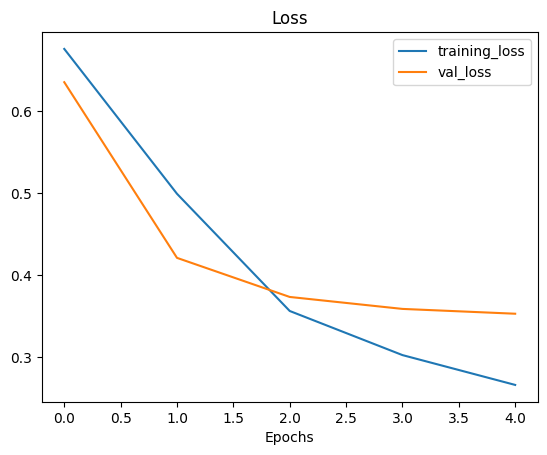

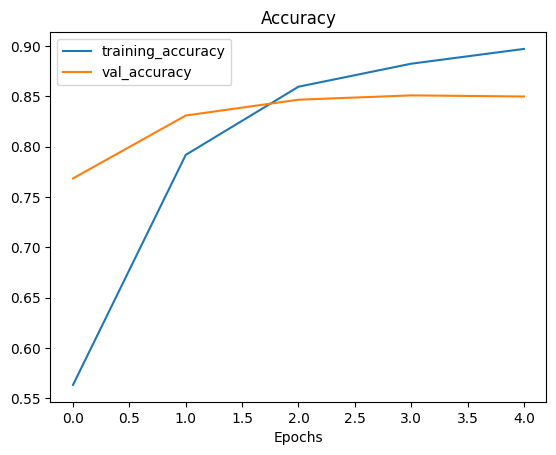

In [126]:
from helper_functions import plot_loss_curves

plot_loss_curves(history_1)

In [127]:
from helper_functions import calculate_results

def pred_show_results(model,val_ds):

  ckt_path = os.path.join('checkpoints',f'{model.name}.h5')
  model.load_weights(ckt_path)

  pred_prob = model.predict(val_ds)
  pred = np.round(np.squeeze(pred_prob))

  val_labels = [x.numpy() for x in val_ds.unbatch().map(lambda x,y : y)]

  results = calculate_results(y_true = val_labels, y_pred = pred)
  return results

In [128]:
results_1 = pred_show_results(model_1, val_ds)
results_1

167/167 [==============================] - 0s 1ms/step


{'accuracy': 0.8509921377761138,
 'precision': 0.8525090174602149,
 'recall': 0.8509921377761138,
 'f1': 0.8513612814978408}

### Model 2:

- with convolutions and max pooling

In [129]:
inputs = tf.keras.Input(shape = [padding_size], name = 'input_layer')
x = embedding_layer(inputs)
x = layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Flatten()(x)
x = layers.Dense(units = 16, activation = 'relu')(x)
outputs = layers.Dense(units = 1, activation = 'sigmoid')(x)
model_2 = tf.keras.Model(inputs,outputs, name = 'model_2')

model_2.compile(loss = tf.keras.losses.binary_crossentropy,
                optimizer = Adam(),
                metrics = ['accuracy'])

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 16)           160000    
                                                                 
 conv1d_5 (Conv1D)           (None, 124, 32)           2592      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 62, 32)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1984)              0         
                                                                 
 dense_10 (Dense)            (None, 16)                31760     
                                                           

In [130]:
history_2 = model_2.fit(train_ds,
                        steps_per_epoch = len(train_ds),
                        epochs = 5, 
                        validation_data = val_ds,
                        validation_steps = len(val_ds),
                        callbacks = [create_model_checkpoint(model_name = model_2.name)])

Epoch 1/5
668/668 [==============================] - 10s 14ms/step - loss: 0.2617 - accuracy: 0.8934 - val_loss: 0.3492 - val_accuracy: 0.8547
Epoch 2/5
668/668 [==============================] - 9s 14ms/step - loss: 0.2011 - accuracy: 0.9217 - val_loss: 0.3532 - val_accuracy: 0.8583
Epoch 3/5
668/668 [==============================] - 7s 10ms/step - loss: 0.1632 - accuracy: 0.9398 - val_loss: 0.3848 - val_accuracy: 0.8615
Epoch 4/5
668/668 [==============================] - 8s 13ms/step - loss: 0.1209 - accuracy: 0.9571 - val_loss: 0.4205 - val_accuracy: 0.8559
Epoch 5/5
668/668 [==============================] - 9s 13ms/step - loss: 0.0760 - accuracy: 0.9755 - val_loss: 0.4809 - val_accuracy: 0.8553


In [131]:
results_2 = pred_show_results(model_1, val_ds)
results_2

167/167 [==============================] - 0s 2ms/step


{'accuracy': 0.8509921377761138,
 'precision': 0.8525090174602149,
 'recall': 0.8509921377761138,
 'f1': 0.8513612814978408}

### Model 3:

- With more convolutions

In [132]:
inputs = tf.keras.Input(shape = [padding_size], name = 'input_layer')
x = embedding_layer(inputs)
x = layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Conv1D(filters = 64, kernel_size = 5, activation = 'relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Flatten()(x)
x = layers.Dense(units = 16, activation = 'relu')(x)
outputs = layers.Dense(units = 1, activation = 'sigmoid')(x)
model_3 = tf.keras.Model(inputs,outputs, name = 'model_3')

model_3.compile(loss = tf.keras.losses.binary_crossentropy,
                optimizer = Adam(),
                metrics = ['accuracy'])

model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 16)           160000    
                                                                 
 conv1d_6 (Conv1D)           (None, 124, 32)           2592      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 62, 32)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 58, 64)            10304     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 29, 64)           0         
 1D)                                                       

In [133]:
history_3 = model_3.fit(train_ds,
                        steps_per_epoch = len(train_ds),
                        epochs = 5, 
                        validation_data = val_ds,
                        validation_steps = len(val_ds),
                        callbacks = [create_model_checkpoint(model_name = model_3.name)])

Epoch 1/5
668/668 [==============================] - 12s 17ms/step - loss: 0.2652 - accuracy: 0.8922 - val_loss: 0.3424 - val_accuracy: 0.8583
Epoch 2/5
668/668 [==============================] - 12s 19ms/step - loss: 0.1981 - accuracy: 0.9234 - val_loss: 0.3779 - val_accuracy: 0.8525
Epoch 3/5
668/668 [==============================] - 11s 17ms/step - loss: 0.1525 - accuracy: 0.9424 - val_loss: 0.4014 - val_accuracy: 0.8570
Epoch 4/5
668/668 [==============================] - 15s 22ms/step - loss: 0.0998 - accuracy: 0.9642 - val_loss: 0.4702 - val_accuracy: 0.8575
Epoch 5/5
668/668 [==============================] - 13s 20ms/step - loss: 0.0545 - accuracy: 0.9838 - val_loss: 0.5852 - val_accuracy: 0.8547


In [134]:
results_3 = pred_show_results(model_3, val_ds)
results_3

167/167 [==============================] - 1s 4ms/step


{'accuracy': 0.858292774241857,
 'precision': 0.8581222399518666,
 'recall': 0.858292774241857,
 'f1': 0.8581818332587206}

### Model 4:

- Add some of the dropouts to the model 3

In [135]:
inputs = tf.keras.Input(shape = [padding_size], name = 'input_layer')
x = embedding_layer(inputs)
x = layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Conv1D(filters = 64, kernel_size = 5, activation = 'relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(units = 16, activation = 'relu')(x)
outputs = layers.Dense(units = 1, activation = 'sigmoid')(x)
model_4 = tf.keras.Model(inputs,outputs, name = 'model_4')

model_4.compile(loss = tf.keras.losses.binary_crossentropy,
                optimizer = Adam(),
                metrics = ['accuracy'])

model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 16)           160000    
                                                                 
 conv1d_8 (Conv1D)           (None, 124, 32)           2592      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 62, 32)           0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 58, 64)            10304     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 29, 64)           0         
 1D)                                                       

In [136]:
history_4 = model_4.fit(train_ds,
                        steps_per_epoch = len(train_ds),
                        epochs = 5, 
                        validation_data = val_ds,
                        validation_steps = len(val_ds),
                        callbacks = [create_model_checkpoint(model_name = model_4.name)])

results_4 = pred_show_results(model_4, val_ds)
results_4

Epoch 1/5
668/668 [==============================] - 16s 22ms/step - loss: 0.2504 - accuracy: 0.8987 - val_loss: 0.3553 - val_accuracy: 0.8572
Epoch 2/5
668/668 [==============================] - 14s 21ms/step - loss: 0.1876 - accuracy: 0.9276 - val_loss: 0.4007 - val_accuracy: 0.8566
Epoch 3/5
668/668 [==============================] - 15s 22ms/step - loss: 0.1509 - accuracy: 0.9445 - val_loss: 0.3847 - val_accuracy: 0.8551
Epoch 4/5
668/668 [==============================] - 23s 34ms/step - loss: 0.1073 - accuracy: 0.9624 - val_loss: 0.5006 - val_accuracy: 0.8517
Epoch 5/5
167/167 [==============================] - 2s 9ms/step


{'accuracy': 0.8571695994009734,
 'precision': 0.8569088697829089,
 'recall': 0.8571695994009734,
 'f1': 0.8568071894828785}

### Model : 5

- Introduce the LSTM

In [137]:
inputs = tf.keras.Input(shape = [padding_size], name = 'input_layer')
x = embedding_layer(inputs)
x = layers.LSTM(units = 32)(x)
x = layers.Dense(units = 16, activation = 'relu')(x)
outputs = layers.Dense(units = 1, activation = 'sigmoid')(x)
model_5 = tf.keras.Model(inputs,outputs, name = 'model_5')

model_5.compile(loss = tf.keras.losses.binary_crossentropy,
                optimizer = Adam(),
                metrics = ['accuracy'])

model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 16)           160000    
                                                                 
 lstm (LSTM)                 (None, 32)                6272      
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 166,817
Trainable params: 166,817
Non-trainable params: 0
_________________________________________________________________


In [138]:
history_5 = model_5.fit(train_ds,
                        steps_per_epoch = len(train_ds),
                        epochs = 5, 
                        validation_data = val_ds,
                        validation_steps = len(val_ds),
                        callbacks = [create_model_checkpoint(model_name = model_5.name)])

results_5 = pred_show_results(model_5, val_ds)
results_5

Epoch 1/5
668/668 [==============================] - 80s 112ms/step - loss: 0.6865 - accuracy: 0.5593 - val_loss: 0.6839 - val_accuracy: 0.5680
Epoch 2/5
668/668 [==============================] - 54s 81ms/step - loss: 0.6864 - accuracy: 0.5593 - val_loss: 0.6839 - val_accuracy: 0.5680
Epoch 3/5
668/668 [==============================] - 51s 77ms/step - loss: 0.6863 - accuracy: 0.5593 - val_loss: 0.6841 - val_accuracy: 0.5680
Epoch 4/5
668/668 [==============================] - 53s 79ms/step - loss: 0.6863 - accuracy: 0.5593 - val_loss: 0.6841 - val_accuracy: 0.5680
Epoch 5/5
167/167 [==============================] - 1s 8ms/step


{'accuracy': 0.8571695994009734,
 'precision': 0.8569088697829089,
 'recall': 0.8571695994009734,
 'f1': 0.8568071894828785}

### Model : 6

-- indtroducing a bi-dircetional LSTM

In [143]:
inputs = tf.keras.Input(shape = [padding_size], name = 'input_layer')
x = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(units = 32))(x)
x = layers.Dense(units = 16, activation = 'relu')(x)
outputs = layers.Dense(units = 1, activation = 'sigmoid')(x)
model_6 = tf.keras.Model(inputs,outputs, name = 'model_6')

model_6.compile(loss = tf.keras.losses.binary_crossentropy,
                optimizer = Adam(),
                metrics = ['accuracy'])

model_6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_20 (Dense)            (None, 16)                1040      
                                                                 
 dense_21 (Dense)            (None, 1)                 17        
                                                                 
Total params: 173,601
Trainable params: 173,601
Non-trainable params: 0
_____________________________________________________

In [144]:
history_6 = model_6.fit(train_ds,
                        steps_per_epoch = len(train_ds),
                        epochs = 5, 
                        validation_data = val_ds,
                        validation_steps = len(val_ds),
                        callbacks = [create_model_checkpoint(model_name = model_6.name)])


Epoch 1/5
668/668 [==============================] - 92s 127ms/step - loss: 0.1603 - accuracy: 0.9441 - val_loss: 0.4899 - val_accuracy: 0.8467
Epoch 2/5
668/668 [==============================] - 89s 133ms/step - loss: 0.0802 - accuracy: 0.9732 - val_loss: 0.6213 - val_accuracy: 0.8446
Epoch 3/5
668/668 [==============================] - 86s 128ms/step - loss: 0.0505 - accuracy: 0.9844 - val_loss: 0.8302 - val_accuracy: 0.8428
Epoch 4/5
668/668 [==============================] - 93s 139ms/step - loss: 0.0335 - accuracy: 0.9905 - val_loss: 0.8358 - val_accuracy: 0.8501
Epoch 5/5
668/668 [==============================] - 90s 135ms/step - loss: 0.0216 - accuracy: 0.9945 - val_loss: 1.0787 - val_accuracy: 0.8388


In [145]:
results_6 = pred_show_results(model_6, val_ds)
results_6

167/167 [==============================] - 6s 25ms/step


{'accuracy': 0.8500561587420442,
 'precision': 0.8498822280453644,
 'recall': 0.8500561587420442,
 'f1': 0.8499471664953061}

In [146]:
all_results = pd.DataFrame({model_1.name:results_1,
                            model_2.name:results_2,
                            model_3.name:results_3,
                            model_4.name:results_4,
                            model_5.name:results_5,
                            model_6.name:results_6}).transpose()

all_results.sort_values(by = 'f1', ascending = False, inplace = True)
all_results

,accuracy,precision,recall,f1
model_3,0.858293,0.858122,0.858293,0.858182
model_4,0.857170,0.856909,0.857170,0.856807
model_5,0.857170,0.856909,0.857170,0.856807
model_1,0.850992,0.852509,0.850992,0.851361
model_2,0.850992,0.852509,0.850992,0.851361
model_6,0.850056,0.849882,0.850056,0.849947


In [147]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 16)           160000    
                                                                 
 conv1d_6 (Conv1D)           (None, 124, 32)           2592      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 62, 32)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 58, 64)            10304     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 29, 64)           0         
 1D)                                                       

In [148]:
model_3.load_weights('checkpoints/model_3.h5')

In [149]:
model_3.save('best_model.h5')

In [151]:
loaded_model = tf.keras.models.load_model('best_model.h5')
loaded_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 16)           160000    
                                                                 
 conv1d_6 (Conv1D)           (None, 124, 32)           2592      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 62, 32)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 58, 64)            10304     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 29, 64)           0         
 1D)                                                       

In [153]:
loaded_model.evaluate(val_ds)

167/167 [==============================] - 3s 15ms/step - loss: 0.3424 - accuracy: 0.8583


[0.34239068627357483, 0.8582927584648132]

### - End of the Notebook